# Implement DEA's Burn Cube method for fire scar and severity mapping

## Load packages

In [1]:
%matplotlib inline

import os
import re
import geopandas as gpd
import rioxarray
import rasterio.features

from skimage import morphology 
from scipy import ndimage
from shapely.geometry import shape
from shapely.geometry import Polygon
from datacube.utils.geometry import Geometry, CRS
from datacube.utils.cog import write_cog
from odc.dscache.tools.tiling import parse_gridspec_with_name
from typing import List, Tuple

import datacube
from datacube.utils import cog
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

In [2]:
from BurnCube_functions import distances,outliers
from severity_functions import severitymapping

## Define functions - move to module script once working

## Connect to datacube

In [3]:
dc = datacube.Datacube(app="Burnt_area_mapping")

## Create local dask cluster

In [4]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39869,Workers: 1
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:38867,Total threads: 2
Dashboard: /user/whusggliuqx@gmail.com/proxy/35547/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:34663,


## Select location

In [5]:
# Set the central latitude and longitude - Clyde Mountain
central_lat = -35.653031
central_lon = 150.231667

# Set the buffer to load around the central coordinates
buffer = 0.06

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

## Load Sentinel-2 data covering the event date(s)

In [6]:
n_years=4
n_years_pre=3.5
# Rough fire event date: used to decide on analysis period around it
fire_date = '2020-01-05'

time_step_before = timedelta(days=365*n_years_pre)
time_step_after = timedelta(days=365*(n_years-n_years_pre))
# time_step_before = timedelta(days=365*0.5) # testing
# time_step_after = timedelta(days=365*0.1)

# Calculate the start and end date for data query
start_date = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - time_step_before), '%Y-%m-%d')
end_date = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + time_step_after),'%Y-%m-%d')

# Print dates
print(f'start_date:  {start_date}')
print(f'end_date:    {end_date}')
print(f'fire_date:       {fire_date}')

start_date:  2016-07-06
end_date:    2020-07-05
fire_date:       2020-01-05


In [7]:
resolution = (-20, 20)
measurements = ['nbart_blue', 'nbart_green', 'nbart_red','nbart_nir_1', 'nbart_swir_3']
min_gooddata = 0.8
output_crs = 'EPSG:3577'
dask_chunks = {'x': 300, 'y': 300}

In [8]:
# Load all data in baseline period available from ARD data
ds = load_ard(dc=dc,
              products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
              x=study_area_lon,
              y=study_area_lat,
              time=(start_date, end_date),
              measurements=measurements,
              min_gooddata=min_gooddata,
              output_crs=output_crs,
              resolution=resolution,
              dask_chunks=dask_chunks,
              group_by='solar_day')
ds

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 134 out of 250 time steps with at least 80.0% good quality pixels
Applying fmask pixel quality/cloud mask
Returning 134 time steps as a dask array


<xarray.Dataset>
Dimensions:       (time: 134, y: 738, x: 633)
Coordinates:
  * time          (time) datetime64[ns] 2016-07-09T00:06:32.455000 ... 2020-0...
  * y             (y) float64 -4.005e+06 -4.005e+06 ... -4.02e+06 -4.02e+06
  * x             (x) float64 1.637e+06 1.637e+06 ... 1.65e+06 1.65e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    nbart_nir_1   (time, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    nbart_swir_3  (time, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

## Calculate Normalized Burn Ratio (NBR) and Geomedian

In [9]:
# Calculate NBR
ds = calculate_indices(ds,
                       index='NBR',
                       collection='ga_s2_3',
                       drop=False)

# Compute median using all observations in the dataset along the time axis
ds_gm = ds.median(dim='time')
# ds_gm.NBR.plot()

## Calculate cosine and euclidian distances

In [10]:
%%time
ds_dist = distances(ds.to_array(), ds_gm.to_array())

/env/lib/python3.10/site-packages/dask/array/core.py:1702: RuntimeWarning: invalid value encountered in cast
  x = x.astype(dtype)
/home/jovyan/Natural_Hazards_Mapping/BurnCube_functions.py:255: RuntimeWarning: invalid value encountered in divide
  nbr = (ard[3, :, i] - ard[4, :, i]) / (ard[3, :, i] + ard[4, :, i])


CPU times: user 1min 40s, sys: 16.4 s, total: 1min 57s
Wall time: 27min 40s


In [11]:
ds_dist

<xarray.Dataset>
Dimensions:      (y: 738, x: 633, time: 134, variable: 6)
Coordinates:
  * y            (y) float64 -4.005e+06 -4.005e+06 ... -4.02e+06 -4.02e+06
    spatial_ref  int32 3577
  * x            (x) float64 1.637e+06 1.637e+06 1.637e+06 ... 1.65e+06 1.65e+06
  * time         (time) datetime64[ns] 2016-07-09T00:06:32.455000 ... 2020-07...
    band         (variable, time, y, x) float32 dask.array<chunksize=(1, 1, 300, 300), meta=np.ndarray>
Dimensions without coordinates: variable
Data variables:
    CDist        (time, y, x) float32 0.01082 0.005383 ... 0.008119 0.01079
    NBRDist      (time, y, x) float32 0.1972 0.1521 0.1468 ... 0.003439 0.2915
    ChangeDir    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NBR          (time, y, x) float32 dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577

## Calculate outliers

In [12]:
%%time
outliers_result = outliers(ds, ds_dist)
# outliers_result.NBRoutlier.plot.imshow(robust=True,cmap='Blues')

2024-01-31 11:02:52,463 begin to process outlier


CPU times: user 1.25 s, sys: 155 ms, total: 1.41 s
Wall time: 1.36 s


## Burn severity mapping - no hotspots data used for now (historic hotspot csv is too big for sandbox)

In [16]:
%%time
map_period=("2020-01-01", "2020-02-01")
burn_cube_result = severitymapping(
        ds_dist,
        outliers_result,
        map_period,
        hotspotfile=None,
        method="NBR",
        # method="NBRdist",
        growing=True,
    )

/tmp/ipykernel_2013/2284775674.py:490: RuntimeWarning: invalid value encountered in cast
  out["Duration"] = (("y", "x"), duration.astype(np.int16))
2024-01-31 12:09:19,295 no hotspots data


CPU times: user 3min 51s, sys: 34.3 s, total: 4min 26s
Wall time: 34min 38s


In [17]:
burn_cube_result

<xarray.Dataset>
Dimensions:      (y: 738, x: 633)
Coordinates:
  * y            (y) float64 -4.005e+06 -4.005e+06 ... -4.02e+06 -4.02e+06
    spatial_ref  int32 3577
  * x            (x) float64 1.637e+06 1.637e+06 1.637e+06 ... 1.65e+06 1.65e+06
Data variables:
    StartDate    (y, x) float64 1.577e+18 1.577e+18 1.577e+18 ... nan nan nan
    Duration     (y, x) int16 0 0 0 0 0 44 29 5 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    Severity     (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Severe       (y, x) int16 0 0 0 0 0 1 1 1 0 0 0 1 ... 0 0 0 0 0 0 0 0 0 0 0
    Count        (y, x) int16 dask.array<chunksize=(300, 300), meta=np.ndarray>
    Moderate     (y, x) int16 1 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0
    Corroborate  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

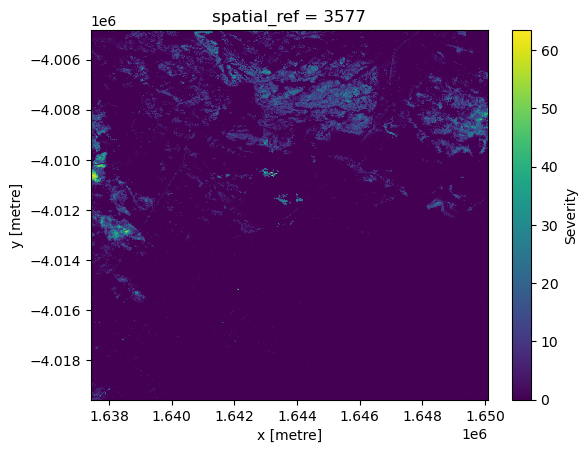

In [18]:
burn_cube_result.Severity.plot()

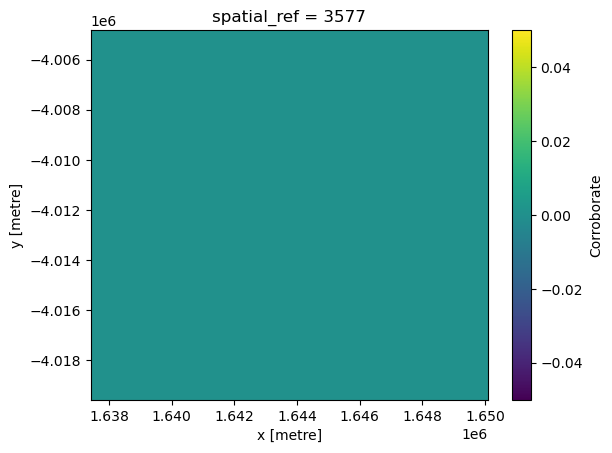

In [19]:
burn_cube_result.Corroborate.plot()

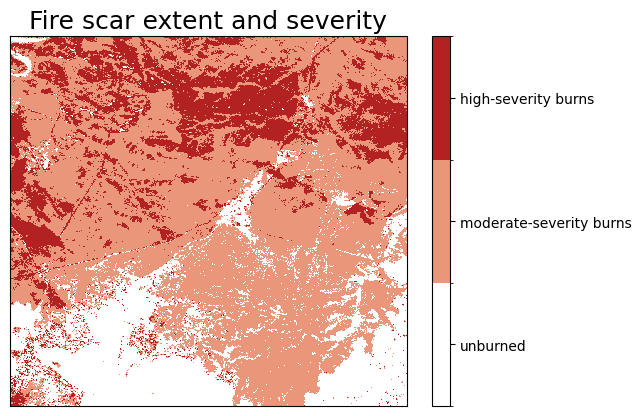

In [20]:
#plot both high and moderate burns
Allburnt = burn_cube_result.Severe + burn_cube_result.Moderate
from matplotlib.colors import ListedColormap
fig,axes=plt.subplots()
cMap = ListedColormap(['white','darksalmon','firebrick'])
cax=Allburnt.plot.imshow(cmap=cMap,levels=[0,1,2,3],add_colorbar=False)
cax.axes.set_title('Fire scar extent and severity',fontsize=18)
cbar = fig.colorbar(cax,ticks=[0.5,1.5,2.5])
cbar.ax.set_yticklabels(['unburned','moderate-severity burns','high-severity burns'])
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)

## Export as GeoTiff

In [21]:
from datacube.utils.cog import write_cog
write_cog(geo_im=burn_cube_result.Severity,
          fname='Clyde_mountain_severity.tif',
          overwrite=True)
write_cog(geo_im=burn_cube_result.Severe,
          fname='Clyde_mountain_Severe.tif',
          overwrite=True)
write_cog(geo_im=burn_cube_result.Moderate,
          fname='Clyde_mountain_Moderate.tif',
          overwrite=True)

2024-01-31 13:24:53,435 CPLE_NotSupported in driver GTiff does not support creation option WIDTH
2024-01-31 13:24:53,436 CPLE_NotSupported in driver GTiff does not support creation option HEIGHT
2024-01-31 13:24:53,437 CPLE_NotSupported in driver GTiff does not support creation option COUNT
2024-01-31 13:24:53,437 CPLE_NotSupported in driver GTiff does not support creation option DTYPE
2024-01-31 13:24:53,437 CPLE_NotSupported in driver GTiff does not support creation option CRS
2024-01-31 13:24:53,438 CPLE_NotSupported in driver GTiff does not support creation option TRANSFORM
2024-01-31 13:24:53,532 CPLE_NotSupported in driver GTiff does not support creation option WIDTH
2024-01-31 13:24:53,533 CPLE_NotSupported in driver GTiff does not support creation option HEIGHT
2024-01-31 13:24:53,533 CPLE_NotSupported in driver GTiff does not support creation option COUNT
2024-01-31 13:24:53,534 CPLE_NotSupported in driver GTiff does not support creation option DTYPE
2024-01-31 13:24:53,534 CP

PosixPath('Clyde_mountain_Moderate.tif')